In [ ]:
#=== DOWNLOAD MODULES FIRST!! ===
!pip install iso3166
!pip install python-iso639

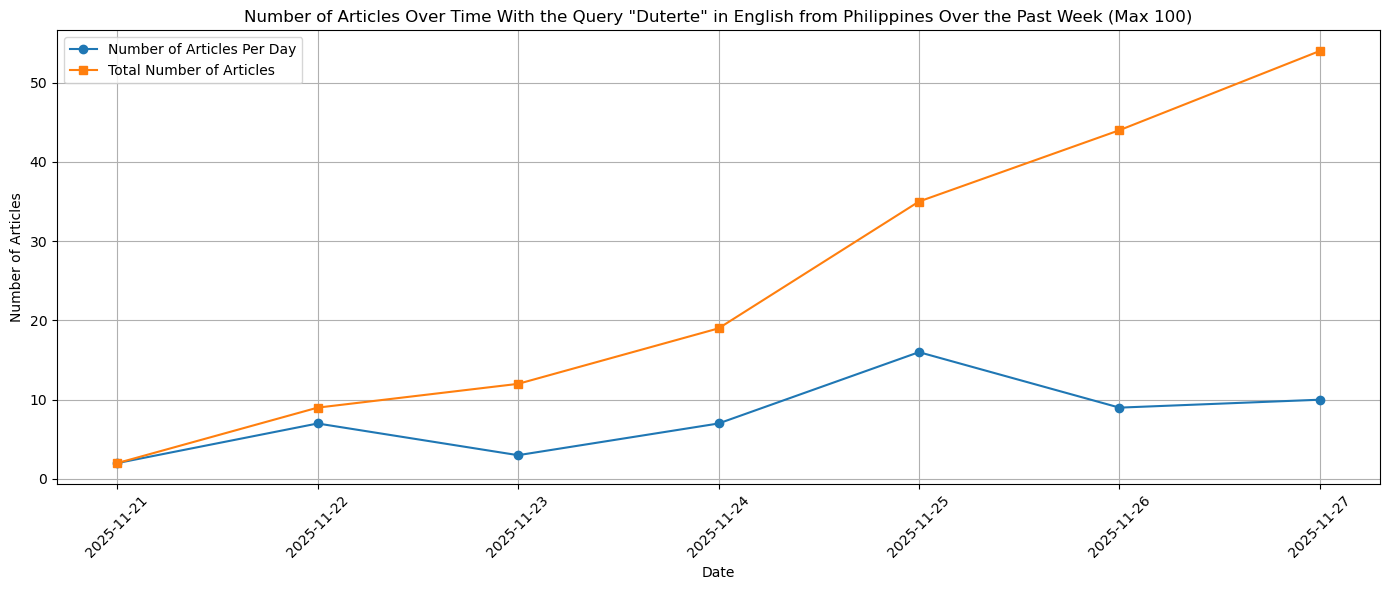

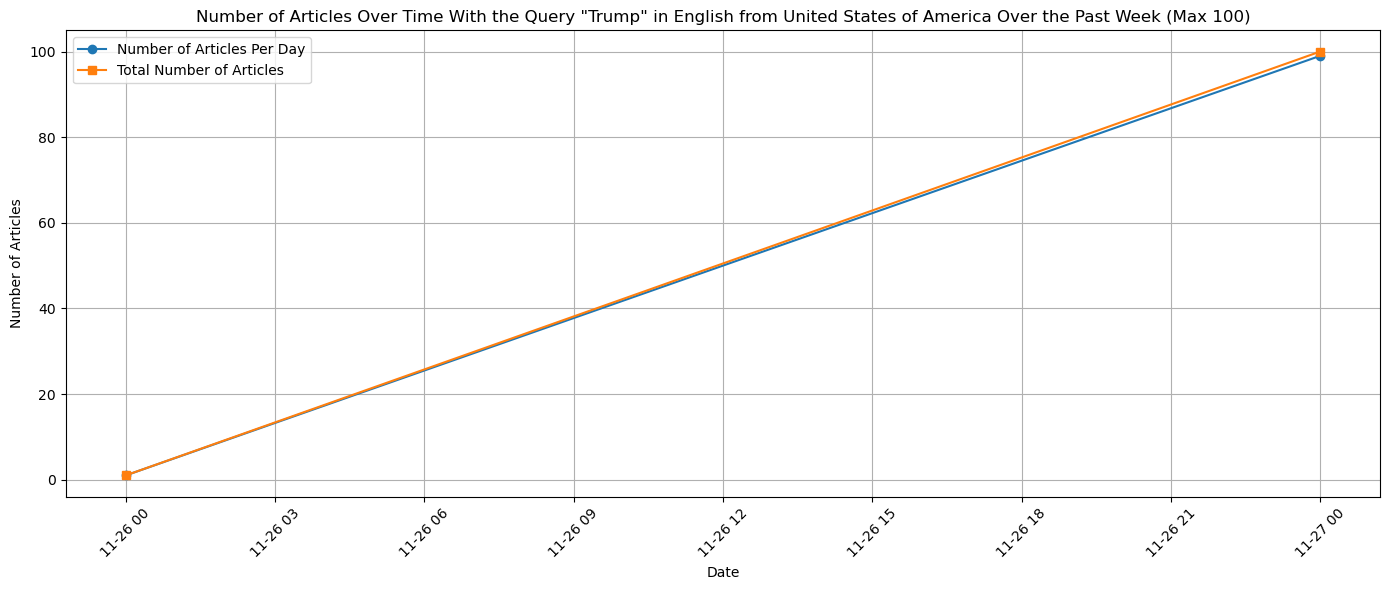

In [12]:
import requests
from iso3166 import countries
import iso639
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import tkinter as tk
from tkinter import ttk
from tkinter import messagebox
import tkinter.font as tkfont
import math

#=== LISTS AND DICTIONARIES OF COUNTRY AND LANGUAGE CODES ===
country_dict = {country.name.title(): country.alpha2.lower() for country in countries}
country_list = sorted([country.name.title() for country in countries])
language_dict = {language.name.title(): language.part1 for language in iso639.ALL_LANGUAGES if language.part1 is not None}
language_list = sorted([language.name.title() for language in iso639.ALL_LANGUAGES if language.part1 is not None])

#=== API PARAMETERS ===
API_KEY = "a7f10f70541d4031ad484fb1ad095c73"
BASE_URL = "https://api.worldnewsapi.com/search-news"

#=== API CALLS ===
def get_search_news_results(query: str, language: str | None = None, country: str | None = None, offset: str = "0"):
    params = {
        "api-key" : API_KEY,
        "text" : f"\"{query.strip()}\"",
        "text-match-indexes" : "title,content",
        "number": "5",
        "offset": offset
    }

    if language is not None:
        params["language"] = language.lower()

    if country is not None:
        params["source-country"] = country.lower()


    response = requests.get(BASE_URL, params=params)

    if response.status_code == 200:
        return response.json()
    else:
        return None

def get_week_results(query: str, language: str | None = None, country: str | None = None):
    params = {
        "api-key" : API_KEY,
        "text" : f"\"{query.strip()}\"",
        "text-match-indexes" : "title,content",
        "number": "100",
        "earliest-publish-date": (datetime.today() - timedelta(weeks=1)).strftime("%Y-%m-%d")
    }

    if language is not None:
        params["language"] = language.lower()

    if country is not None:
        params["source-country"] = country.lower()


    response = requests.get(BASE_URL, params=params)

    if response.status_code == 200:
        return response.json()
    else:
        return None

#===TKINTER GUI APP
class GlobalNewsSearch:
    def __init__(self, root):
        self.root = root
        root.title("Global News Search")
        self.rows = 2
        self.search_done = False

        self.search_label = tk.Label(root, text="Search: ")
        self.search_label.grid(row=0, column=0, padx=5, pady=5, sticky="w")

        self.search_entry = tk.Entry(root, width=50)
        self.search_entry.grid(row=0, column=1, columnspan=40, padx=5, pady=5, sticky="w")

        self.language_label = tk.Label(root, text="Language: ")
        self.language_label.grid(row=0, column=41, padx=5, pady=5, sticky="w")

        self.language_comboBox = ttk.Combobox(root, values=language_list)
        self.language_comboBox.grid(row=0, column=42, columnspan=10, padx=5, pady=5, sticky="w")

        self.country_label = tk.Label(root, text="Country: ")
        self.country_label.grid(row=0, column=52, padx=5, pady=5, sticky="w")

        self.country_comboBox = ttk.Combobox(root, values=country_list)
        self.country_comboBox.grid(row=0, column=53, columnspan=10, padx=5, pady=5, sticky="w")

        self.search_btn = tk.Button(root, text="Search", command=self.search_news)
        self.search_btn.grid(row=1, column=0, padx=5, pady=5, sticky="w")

        self.generate_btn = tk.Button(self.root, text="Generate Trend", command=self.generate_trend)
        self.generate_btn.grid(row=1, column=1, sticky="w")

        text_frame = tk.Frame(self.root)
        text_frame.grid(row=2, column=0, columnspan=100, sticky="nsew") 

        self.root.grid_rowconfigure(2, weight=1)
        self.root.grid_columnconfigure(0, weight=1)
        text_frame.grid_rowconfigure(2, weight=1)
        text_frame.grid_columnconfigure(0, weight=1)

        self.scrollbar = tk.Scrollbar(text_frame)
        self.scrollbar.grid(row=2, column=1, columnspan=100, sticky="ns")

        self.text_widget = tk.Text(
            text_frame,
            wrap="word",
            yscrollcommand=self.scrollbar.set,
            font=("Arial", 12)
        )
        self.text_widget.grid(row=2, column=0, columnspan=100, sticky="nsew")
        self.scrollbar.config(command=self.text_widget.yview)


    def search_news(self):
        self.lang_code = self.country_code = None
        self.offset = 0
        self.search_done = True
        self.query = self.search_entry.get().strip()
        if not self.query:
            messagebox.showerror("Error", "Search field must not be empty")
        
        language = self.language_comboBox.get().strip()
        if language:
            self.lang_code = language_dict[language]
            
        
        country = self.country_comboBox.get().strip()
        if country:
            self.country_code = country_dict[country]
        
        self.fetch_page(self.offset)
        
    def generate_trend(self):
        self.lang_code = self.country_code = None
        self.query = self.search_entry.get().strip()
        if not self.query:
            messagebox.showerror("Error", "Search field must not be empty")
        
        language = self.language_comboBox.get().strip()
        if language:
            self.lang_code = language_dict[language]
            
        
        country = self.country_comboBox.get().strip()
        if country:
            self.country_code = country_dict[country]
        
        data = get_week_results(self.query, self.lang_code, self.country_code)
        if data is None:
            messagebox.showerror("Error", "Unable to fetch data. Please check your API or internet connection")
        
        try:
            dates, article_count, article_cumsum = create_data(data)
            plot_count_and_cumsum(dates, article_count, article_cumsum, self.query, self.lang_code, self.country_code)
            self.text_widget.delete("1.0", "end")
            self.text_widget.insert("end", "Plot Generated!\n")
            self.text_widget.yview_moveto(0)

        except Exception as e:
            messagebox.showerror("Error", f"Failed to plot trend data: {e}")
        


    def generate_page_buttons(self):
        if self.search_done:
            self.first_btn = tk.Button(self.root, text="<<", command=self.first_page)
            self.first_btn.grid(row=1, column=2, sticky="w")

            self.prev_btn = tk.Button(self.root, text="<", command=self.prev_page)
            self.prev_btn.grid(row=1,column=3, sticky="w")

            self.pagenum_var = tk.StringVar()

            self.pagenum_label = tk.Label(self.root, textvariable=self.pagenum_var)
            self.pagenum_label.grid(row=1, column=4, columnspan=50, sticky="w")

            self.next_btn = tk.Button(self.root, text=">", command=self.next_page)
            self.next_btn.grid(row=1, column=54, sticky="w")

            self.last_btn = tk.Button(self.root, text=">>", command=self.last_page)
            self.last_btn.grid(row=1, column=55, sticky="w")

    def create_search_results(self, data):
        bold_font = tkfont.Font(self.text_widget, self.text_widget.cget("font"))
        bold_font.configure(weight="bold")
        self.text_widget.tag_configure("bold", font=bold_font)

        self.text_widget.delete("1.0", "end")

        self.text_widget.insert("end", "There are ")
        self.text_widget.insert("end", f"{self.total_articles} ", "bold")
        self.text_widget.insert("end", "articles with your query.\n")
        for i, entry in enumerate(data["news"], start=1):
            self.text_widget.insert("end", f"Article {i}\n", "bold")
            self.text_widget.insert("end", "Title: ", "bold")
            self.text_widget.insert("end", f"{entry["title"]}\n")
            self.text_widget.insert("end", "Author: ", "bold")
            self.text_widget.insert("end", f"{entry["author"]}\n")
            self.text_widget.insert("end", "Date Published: ", "bold")
            self.text_widget.insert("end", f"{entry["publish_date"]}\n")
            self.text_widget.insert("end", "Language: ", "bold")
            self.text_widget.insert("end", f"{next((language for language, code in language_dict.items() if code == entry["language"].lower()), None)} || ")
            self.text_widget.insert("end", "Country: ", "bold")
            self.text_widget.insert("end", f"{next((country for country, code in country_dict.items() if code == entry["source_country"].lower()), None)}\n")
            self.text_widget.insert("end", "Text: ", "bold")
            self.text_widget.insert("end", f"{entry["text"][:297].replace('\n', ' ') + "..."}\n")
            self.text_widget.insert("end", "Continue reading at: ", "bold")
            self.text_widget.insert("end", f"{entry["url"]}\n")
            self.text_widget.insert("end", "\n" + "-"*60 + "\n\n") 

        self.text_widget.yview_moveto(0)
    
    # FETCH A PAGE
    def fetch_page(self, offset):
        data = get_search_news_results(self.query, self.lang_code, self.country_code, offset=str(offset))
        if data is None:
            messagebox.showerror("Error", "Unable to fetch data. Please check your API or internet connection")
        
        self.total_articles = data["available"]
        self.total_pages = max(1, math.ceil(int(data["available"]) / 5))
        self.page = max(1, math.ceil(self.offset // 5) + 1)
        self.create_search_results(data)
        self.generate_page_buttons()
        self.pagenum_var.set(f"Page {self.page} of {self.total_pages}")

    # PAGINATION
    def next_page(self):
        if self.offset + 5 >= self.total_articles:
            return []
        self.offset += 5
        return self.fetch_page(self.offset)

    def prev_page(self):
        if self.offset == 0:
            return []
        self.offset -= 5
        return self.fetch_page(self.offset)

    def first_page(self):
        self.offset = 0
        return self.fetch_page(self.offset)

    def last_page(self):
        self.offset = (self.total_pages - 1) * 5
        return self.fetch_page(self.offset)
        

#=== EXTRACTING DATA TREND
def create_data(data):
    dates_counts = {}
    dates = []
    sum = 0

    for entry in data["news"]:
        dates.append(datetime.fromisoformat(entry["publish_date"]).date())
    
    for date in dates:
        if date in dates_counts:
            dates_counts[date] += 1
        else:
            dates_counts[date] = 1
    
    dates_counts = dict(sorted(dates_counts.items()))

    article_cumsum = []

    for date, count in dates_counts.items():
        sum += count
        article_cumsum.append(sum)

    dates = list(dates_counts.keys())
    article_count = list(dates_counts.values())
    return dates, article_count, article_cumsum

#=== PLOT AND GRAPH DATA
def plot_count_and_cumsum(dates, count, cumsum, query, lang_code: str | None = None, country_code: str | None = None):
    plt.figure(figsize=(14,6))

    plt.plot(dates, count, marker="o", linestyle="-", label="Number of Articles Per Day")
    plt.plot(dates, cumsum, marker="s", linestyle="-", label="Total Number of Articles")

    title = f"Number of Articles Over Time With the Query \"{query}\""
    if lang_code is not None:
        title = title + f" in {iso639.Language.from_part1(lang_code).name}"
    if country_code is not None:
        title = title + f" from {countries.get(country_code).name}"
    title = title + " Over the Past Week (Max 100)"

    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Number of Articles")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def main():
    root = tk.Tk()
    app = GlobalNewsSearch(root)
    root.mainloop()
    

if __name__ == "__main__":
    main()
